In [1]:
import torch
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

from Train import MultivariateSigmoidNormalDiag
from Model import Actor, Critic
from VecEnv import EIEnv


In [2]:
env=EIEnv(gamma=0.9)
[seed]=env.seed()

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
actor_net = Actor(env.observation_space.shape[0],env.action_space.shape[0]-30,30)
critic_net = Critic(env.observation_space.shape[0],30)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_net = actor_net.to(device)
critic_net = critic_net.to(device)
checkpoint = torch.load('./models/best')
actor_net.load_state_dict(checkpoint['actor_model_state_dict'],strict=False)
critic_net.load_state_dict(checkpoint['critic_model_state_dict'],strict=False)
actor_net.eval()
critic_net.eval()

Critic(
  (hiden): Sequential(
    (0): Linear(in_features=76, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
  )
  (gen_v): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (BES_v): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (AC_v): Sequential(
    (0): Linear(in_features=64, out_features=30, bias=True)
  )
)

In [20]:
import torch.distributions as dist
gamma=0.9
env.seed()
steps=np.zeros([1440,76])
values = np.zeros(1440)
with torch.no_grad():
    observation = env.reset()
    for step in range(int(1440)):
    
        observation_in=env.observation_scalar(observation)
        
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        EV_mu, EV_sigma, AC_prob = actor_net(observation_in)
        #if np.sum(env.AC_sign)>0:
        #    print(AC_prob)
        values[step] = critic_net(observation_in).detach().cpu().numpy()
        p = torch.rand(30,device='cuda:0')
        AC_probs = dist.bernoulli.Bernoulli(AC_prob*(p>0.3)+0.5*torch.ones(30,device='cuda:0')*(p<=0.3))
        
        action=torch.cat((EV_mu,AC_probs.sample().to(torch.float)),dim=1)
        # gather env data, reset done envs and update their obs
        observation, reward, done, info = env.step(action.detach().cpu().numpy()[0])
        #steps.append((np.array([reward]), action.detach().cpu().numpy(), env.state ))
        steps[step]=env.state

In [4]:
import torch.distributions as dist
gamma=0.9
env.seed()
steps=np.zeros([1439,76])
gen_costs = []
bes_costs = []
AC_costs = []
values = np.zeros(1439)
with torch.no_grad():
    observation = env.reset()
    for step in range(int(1439)):
    
        observation_in=env.observation_scalar(observation)
        
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        EV_mu, EV_sigma, AC_prob = actor_net(observation_in)
        action=torch.cat((EV_mu,(AC_prob>0.5).to(torch.float)),dim=1)
        # gather env data, reset done envs and update their obs
        observation, gen_cost, bes_cost, AC_cost, _, _= env.step(action.detach().cpu().numpy()[0])
        #steps.append((np.array([reward]), action.detach().cpu().numpy(), env.state ))
        steps[step]=env.state
        gen_costs.append(gen_cost)
        bes_costs.append(bes_cost)
        AC_costs.append(AC_cost)

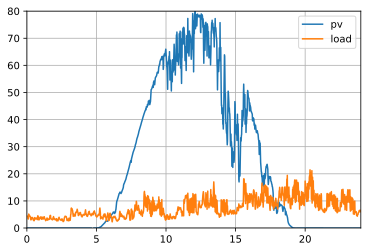

In [5]:
plt.plot(steps[:,0], steps[:,1], label='pv')
plt.plot(steps[:,0], steps[:,4], label='load')
#plt.plot(x[:,0], x[:,2]-x[:,1]-x[:,3]-x[:,4]-x[:,5], label='Pbes')
plt.ylim(0,80)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

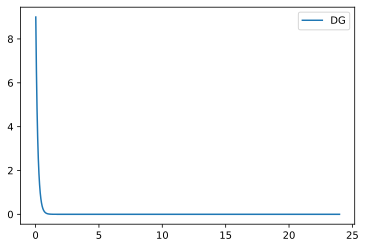

In [6]:
plt.plot(steps[:,0], steps[:,2], label='DG')
plt.legend()
plt.show()

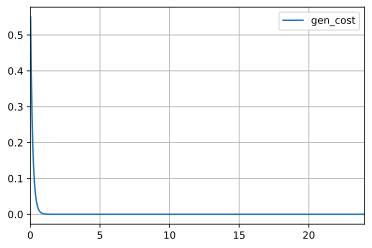

In [7]:
plt.plot(steps[:,0], gen_costs, label='gen_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

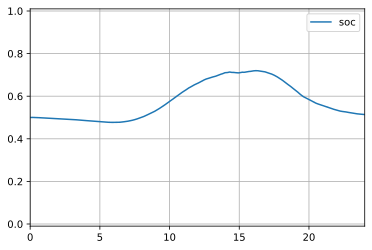

In [8]:
plt.plot(steps[:,0], steps[:,3], label='soc')
plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

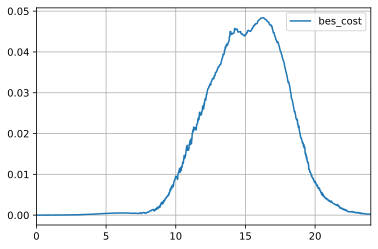

In [9]:
plt.plot(steps[:,0], bes_costs, label='bes_cost')
#plt.ylim(-0.01,1.01)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

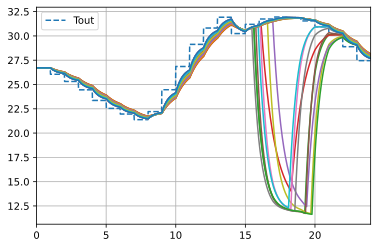

In [10]:
plt.plot(steps[:,0],steps[:,5], '--', label='Tout')
for i in range(30):
    plt.plot(steps[:,0],steps[:,-(i+1)])
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

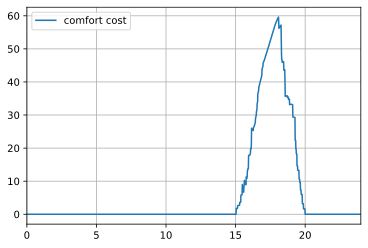

In [11]:
plt.plot(steps[:,0],np.sum(np.array(AC_costs),axis=1), label='comfort cost')
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

In [13]:
num=0
for i in range(30):
    if(np.sum(steps[:,-(i+1)]<20)>0):
        num+=1
print(num)

9


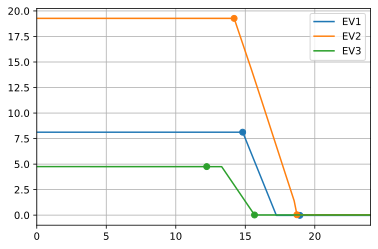

In [14]:
plt.plot(steps[:,0],steps[:,6], 'C0', label='EV1')
plt.plot(env.start_charge_time[0],steps[0,6],'C0o')
plt.plot(env.end_charge_time[0],steps[-1,6],'C0o')
plt.plot(steps[:,0],steps[:,6+10], 'C1', label='EV2')
plt.plot(env.start_charge_time[10],steps[0,16],'C1o')
plt.plot(env.end_charge_time[10],steps[-1,16],'C1o')
plt.plot(steps[:,0],steps[:,6+15],'C2', label='EV3')
plt.plot(env.start_charge_time[15],steps[0,21],'C2o')
plt.plot(env.end_charge_time[15],steps[-1,21],'C2o')
#plt.ylim(-0.1,15)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

NameError: name 'Q_net' is not defined

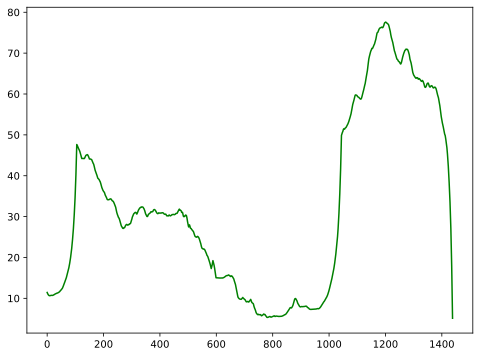

In [25]:
fig, (ax1)=plt.subplots(1,1,figsize=(8,6))
ax1.plot(Q_x_a[:],'g',label='$V(x,t)$ (Simulation)')
ax1.plot(Q_net[:],'r',label='$V(x,t)$ (Learned)')
#ax1.plot(Q[:],'g--',label='Q(x,a)* (Simulation with Random Action)')
ax1.legend()

fig.tight_layout()
fig.show()

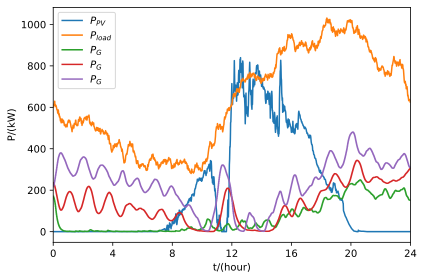

In [8]:
plt.plot(x[:,0],x[:,1],label=r'$P_{PV}$')
plt.plot(x[:,0],x[:,2],label=r'$P_{load}$')
plt.step(x[:,0],x[:,3:6],label=r'$P_G$')
plt.ylabel('P/(kW)')
plt.xlabel('t/(hour)')
plt.xlim([0,24])
plt.xticks(np.arange(0,25,4))
plt.legend()
plt.tight_layout()

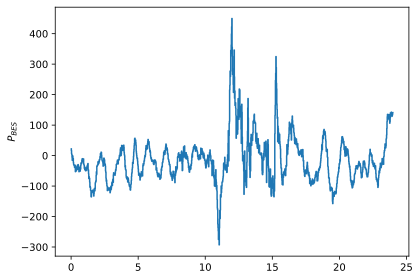

In [9]:
plt.step(x[:,0],x[:,1]-x[:,2]+x[:,3]+x[:,4]+x[:,5])
plt.ylabel(r'$P_{BES}$')
plt.tight_layout()

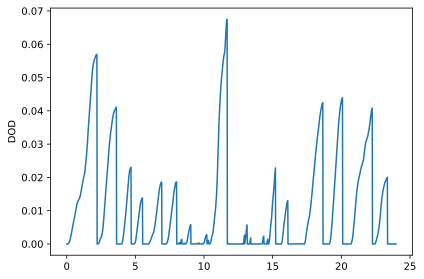

In [10]:
plt.plot(x[:,0],x[:,6])
plt.ylabel('DOD')
plt.tight_layout()

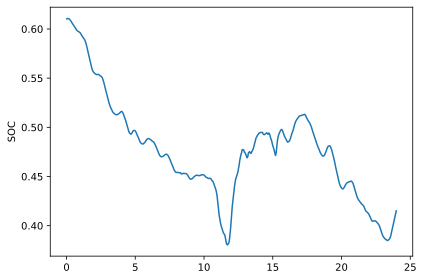

In [11]:
plt.plot(x[:,0],x[:,7])
plt.ylabel('SOC')
plt.tight_layout()

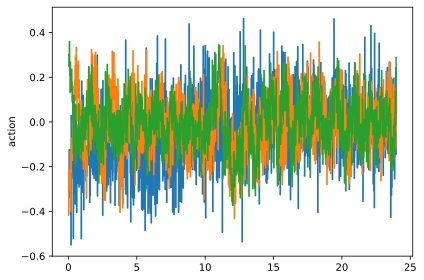

In [12]:
plt.step(x[:,0],a)
plt.ylabel('action')
plt.tight_layout()

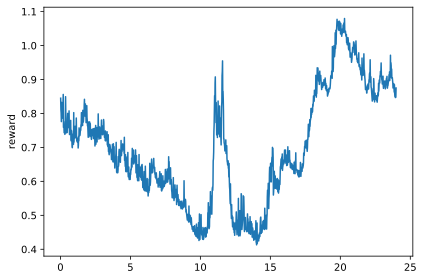

In [13]:
plt.plot(x[:,0],r)
plt.ylabel('reward')
plt.tight_layout()

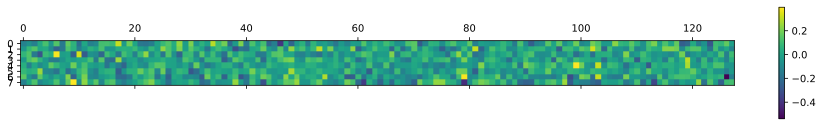

In [14]:
plt.matshow(net.input_feature[0].weight.data.cpu().T)
plt.colorbar()

In [70]:
gamma=0.96
env.seed(9331)
mus=[]
thetas=[]
with torch.no_grad():
    observation = env.preset(soc=0.61)
    while True:
        observation_in=env.observation_scaler(observation)
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        input_feature = net.input_feature(observation_in)
        fc_out=net.fc(input_feature)
        mu_out = net.mu(fc_out)
        sigma_out = net.sigma(fc_out)
        theta_out= net.theta(fc_out)
        v_out = net.v(fc_out)
        mus.append(mu_out.detach().cpu().numpy())
        thetas.append(theta_out.detach().cpu().numpy().reshape((3,-1)))
        policies_mu=mu_out+torch.matmul(observation_in,theta_out.reshape((3,-1)).t())
        action=torch.tanh(policies_mu)
        # gather env data, reset done envs and update their obs
        observation, reward, done, info = env.step(action.detach().cpu().numpy()[0])
        if done:
            break

In [75]:
net.mu

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=128, out_features=3, bias=True)
  (5): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
  (6): Tanh()
)

In [71]:
mus=np.array(mus)
mus=np.squeeze(mus)
thetas=np.array(thetas)
thetas=np.squeeze(thetas)

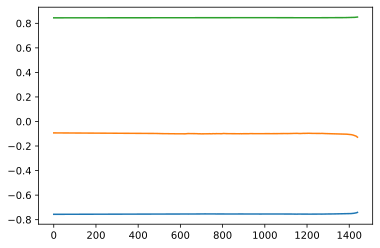

In [72]:
plt.plot(mus)

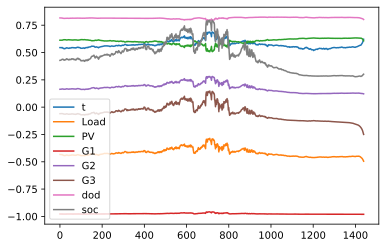

In [105]:
labels=['t','Load','PV','G1','G2','G3','dod','soc']
for i in range(len(labels)):
    plt.plot(thetas[:,0,i],label=labels[i])
plt.legend(loc='best') 

In [79]:
observation = env.preset(0.2)

In [80]:
observation_in=env.observation_scaler(observation)
observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
observation_in= torch.unsqueeze(observation_in,dim=0)
observation_in

tensor([[0.0000, 0.0000, 0.5931, 0.4194, 0.5630, 0.2041, 0.0000, 0.2000]],
       device='cuda:0')

In [103]:
observation_in.requires_grad_()
net.zero_grad()
input_feature = net.input_feature(observation_in)
fc_out=net.fc(input_feature)
mu_out = net.mu(fc_out)
sigma_out = net.sigma(fc_out)
theta_out= net.theta(fc_out)
v_out = net.v(fc_out)
torch.autograd.grad(v_out[:], observation_in)

(tensor([[-0.5257,  1.3696,  0.7486, -1.1521,  0.0298,  0.5777, -1.9428,  0.2364]],
        device='cuda:0'),)

In [42]:
mu=[]
inputs= np.linspace(0,1,50)
with torch.no_grad():
    for i in inputs:
        observation_in[0,3]=i
        policies_mu, _,_= net(observation_in)
        mu.append(policies_mu.detach().cpu().numpy())
mu=np.squeeze(np.array(mu))

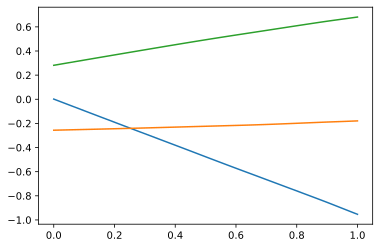

In [43]:
plt.plot(inputs,mu)

In [18]:
input_feature = net.input_feature(observation_in)
fc_out=net.fc(input_feature)
mu_out = net.mu(fc_out)
sigma_out = net.sigma(fc_out)
theta_out = net.theta(fc_out)
v_out = net.v(fc_out)

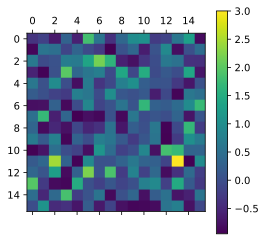

In [19]:
plt.matshow(input_feature.detach().cpu().reshape((16,-1)))
plt.colorbar()

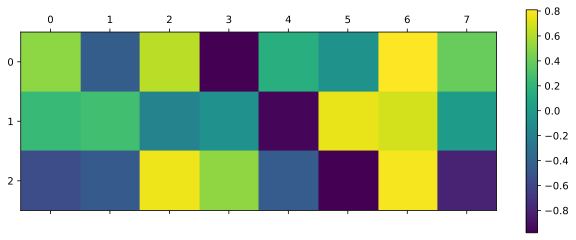

In [20]:
plt.matshow(theta_out.detach().cpu().reshape((3,-1)))
plt.colorbar()

In [21]:
theta_out.detach().cpu().reshape((3,-1))

tensor([[ 0.5085, -0.4524,  0.6256, -0.9797,  0.1507, -0.0641,  0.8097,  0.3971],
        [ 0.2275,  0.2673, -0.1826, -0.0722, -0.9481,  0.7517,  0.6871,  0.0053],
        [-0.5598, -0.4708,  0.7627,  0.5111, -0.4578, -0.9741,  0.7856, -0.8048]])

tensor([[-0.7398, -0.1423,  0.8566]])


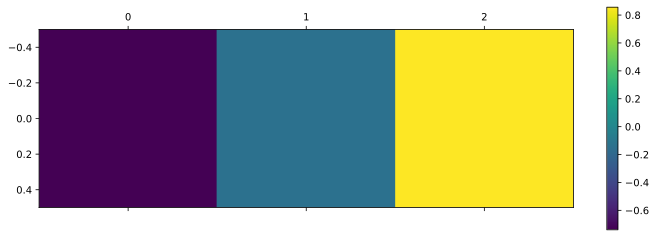

In [114]:
plt.matshow(mu_out.detach().cpu())
plt.colorbar()
print(mu_out.detach().cpu())

In [64]:
policies_mu, _,_=net(observation_in)
action=torch.tanh(policies_mu)
observation, _,_,_ = env.step(action.detach().cpu().numpy()[0])

In [11]:
np.load('./Data/para_b.npy')

array([39.70091904, 33.73590342, 27.42147775, 27.16182235, 33.87194844,
       35.62716071, 23.21764878, 28.79188916, 34.18361587, 21.26672388,
       14.96084448, 17.48885596, 13.7733214 , 17.44231116, 19.52443552,
       19.65853804, 13.59178609, 13.4490881 , 10.57426641, 10.38665029,
        8.90622533, 12.69854451, 11.81065724, 10.81457901, 12.8728148 ,
       12.0512105 ,  8.48482376,  6.73331525, 11.67896595,  8.8766045 ])

In [12]:
np.load('./Data/para_a.npy')

array([1.98504595, 1.68679517, 1.37107389, 1.35809112, 1.69359742,
       1.78135804, 1.16088244, 1.43959446, 1.70918079, 1.06333619,
       1.49608445, 1.7488856 , 1.37733214, 1.74423112, 1.95244355,
       1.9658538 , 1.35917861, 1.34490881, 1.05742664, 1.03866503,
       1.3359338 , 1.90478168, 1.77159859, 1.62218685, 1.93092222,
       1.80768158, 1.27272356, 1.00999729, 1.75184489, 1.33149068])

In [30]:
np.load('./Data/mu.npy')

array([0.1977897 , 0.17460973, 0.15860296, 0.14446108, 0.16557537,
       0.1878191 , 0.10589539, 0.10732941, 0.1312721 , 0.15133268,
       0.19012241, 0.1317525 , 0.16775308, 0.18723328, 0.15474053,
       0.13211005, 0.14484712, 0.19347245, 0.17292972, 0.17632702,
       0.12251651, 0.12384764, 0.11338874, 0.19164669, 0.17005467,
       0.18015119, 0.11041604, 0.19856578, 0.1637906 , 0.17091314])

In [26]:
num = []
n=0
for i in range(1,1000):
    j=1
    while j<i:
        k=1
        while k<j:
            n+=1
            k=k+1
        j = 2*j
    num.append(n)

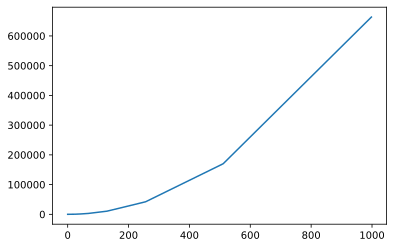

In [27]:
import matplotlib.pyplot as plt
plt.plot(num)
plt.show()

In [22]:
import torch
import numpy as np
gen_cost = np.zeros(10)
gen_cost = torch.from_numpy(gen_cost).float().unsqueeze(1)

In [4]:
import torch
import torch.distributions as dist
A=dist.Normal(torch.zeros([3]),0.1*torch.ones([3]))
sample = A.sample()
A.log_prob(sample)

tensor([1.2487, 1.3488, 1.3684])